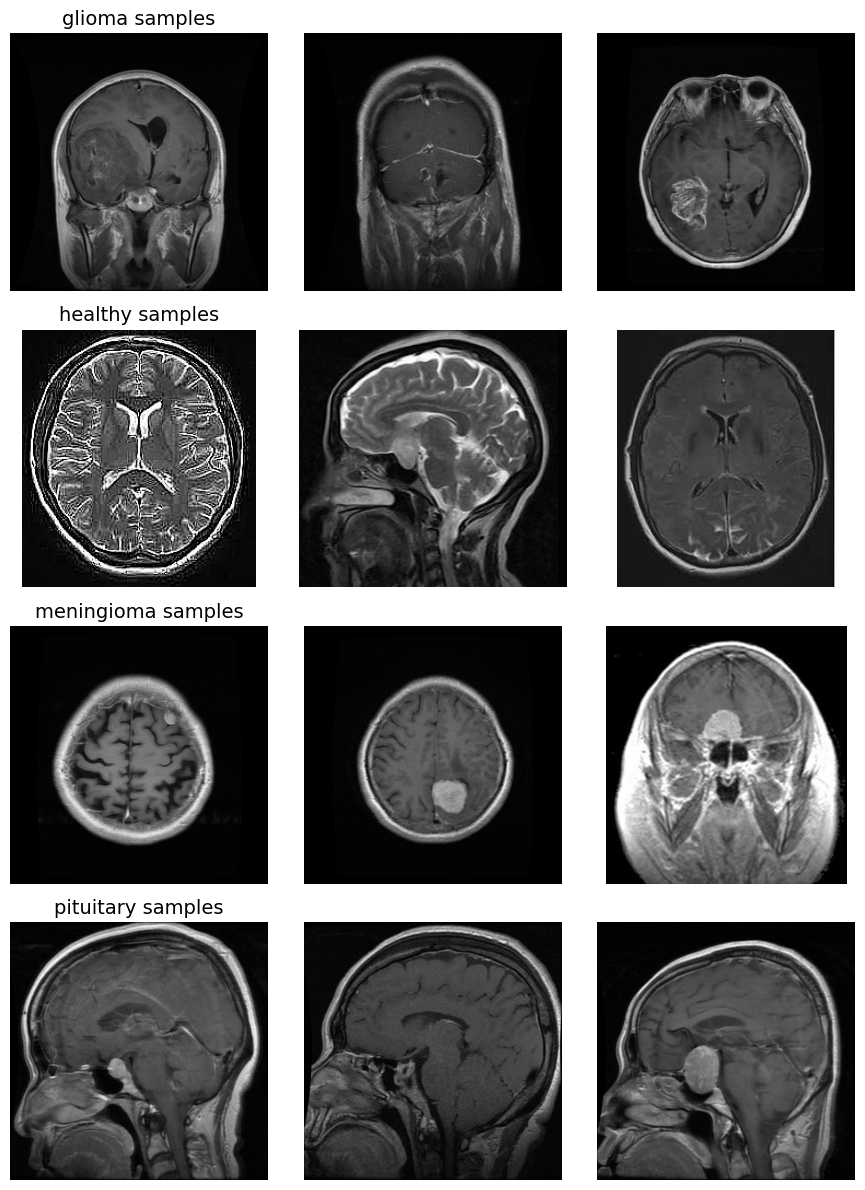

Epoch 1/20
Train loss: 0.4471, Training accuracy: 0.8332, Validation loss: 0.2282, Validation accuracy: 91.6429
Epoch 2/20
Train loss: 0.2693, Training accuracy: 0.9072, Validation loss: 2.1522, Validation accuracy: 51.1871
Epoch 3/20
Train loss: 0.2043, Training accuracy: 0.9298, Validation loss: 1.9022, Validation accuracy: 62.5831
Epoch 4/20
Train loss: 0.1532, Training accuracy: 0.9526, Validation loss: 0.4806, Validation accuracy: 83.9506
Epoch 5/20
Train loss: 0.0991, Training accuracy: 0.9654, Validation loss: 0.4380, Validation accuracy: 86.6097
Epoch 6/20
Train loss: 0.1043, Training accuracy: 0.9636, Validation loss: 0.4761, Validation accuracy: 86.5147
Epoch 7/20
Train loss: 0.0822, Training accuracy: 0.9703, Validation loss: 0.3702, Validation accuracy: 88.4141
Epoch 8/20
Train loss: 0.0470, Training accuracy: 0.9839, Validation loss: 0.0723, Validation accuracy: 97.5309
Epoch 9/20
Train loss: 0.0192, Training accuracy: 0.9949, Validation loss: 0.0773, Validation accuracy: 

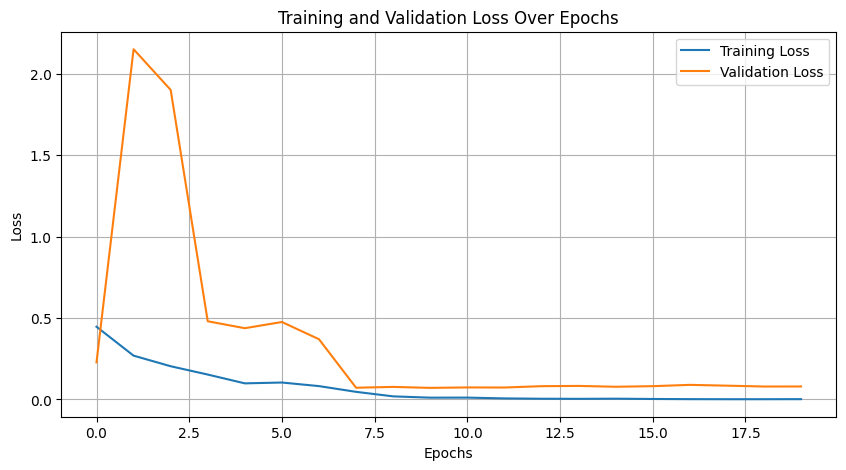

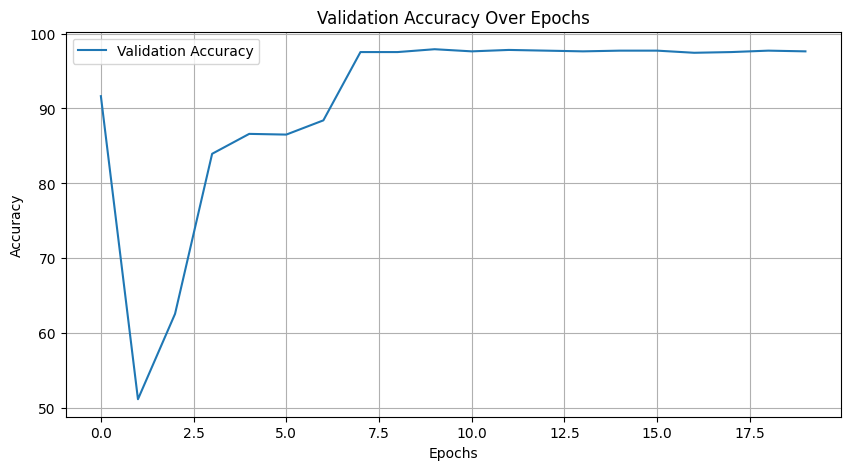

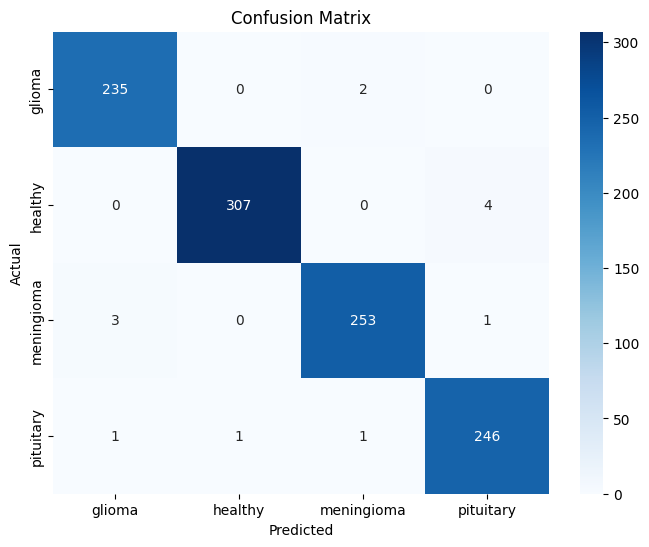

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       237
     healthy       1.00      0.99      0.99       311
  meningioma       0.99      0.98      0.99       257
   pituitary       0.98      0.99      0.98       249

    accuracy                           0.99      1054
   macro avg       0.99      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054



In [11]:
# Import necessary libraries
import numpy as np 
import pandas as pd
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import copy
import time
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations using Albumentations
data_transform = {
    'train' : A.Compose([
        A.Resize(224, 224),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
        A.Rotate(limit=15),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=0, mask_fill_value=None),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),

    'val' : A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}

# Custom dataset class using ImageFolder
class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)
        self.custom_transform = transform

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = np.array(image)

        if self.custom_transform:
            augmented = self.custom_transform(image=image)
            image = augmented['image']

        return image, label

# Set data directory and prepare datasets
data_dir = r'C:\Users\THILAK R\Downloads\brain_tumor_dataset'
full_dataset = CustomImageDataset(data_dir, data_transform['train'])

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.custom_transform = data_transform['val']
test_dataset.dataset.custom_transform = data_transform['val']

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Function to show sample images
def show_sample_images(data_dir, classes, num_samples=3):
    figure, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = random.sample(os.listdir(class_dir), num_samples)
        
        for j, image in enumerate(images):
            img_path = os.path.join(class_dir, image)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_title(f"{cls} samples", fontsize=14)
            
    plt.tight_layout()
    plt.show()

classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
show_sample_images(data_dir, classes)

# Training and evaluation functions
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, target_accuracy=0.99):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total_train_samples += labels.size(0)
        
        training_acc = running_corrects / total_train_samples    
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        
        print(f"Train loss: {running_loss / len(train_loader):.4f}, "
              f"Training accuracy: {training_acc:.4f}, "
              f"Validation loss: {val_loss:.4f}, "
              f"Validation accuracy: {val_acc:.4f}")
        
        history['train_loss'].append(running_loss / len(train_loader))
        history['train_accuracy'].append(training_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        # Early stopping condition
        if val_acc >= target_accuracy * 100:
            print(f"Target accuracy of {target_accuracy * 100}% reached. Stopping training.")
            break
    
    model.load_state_dict(best_model_wts)
    return model, history


def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return running_loss / len(data_loader), correct * 100 / total

# Initialize model, criterion, optimizer, and scheduler
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Train the model
num_epochs = 20
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# Evaluate on test data
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

# Show confusion matrix and classification report
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
all_preds, all_labels = plot_confusion_matrix(model, test_loader, classes)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Save the model
torch.save(model.state_dict(), "model.pth")


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
print(device)


cuda


In [17]:
try:
    torch.save(model.state_dict(), "brain_tumor_model.pth")
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")


Model saved successfully!


In [48]:
import os
if os.path.isfile("brain_tumor_model.pth"):
    print("Model file exists.")
else:
    print("Model file does not exist.")


Model file exists.


In [46]:
import os

# Assuming you saved the model with this line
model_path = "model.pth"

# Get the absolute path
absolute_path = os.path.abspath(model_path)
print(f"Model is saved at: {absolute_path}")


Model is saved at: C:\Users\THILAK R\Downloads\model.pth


In [58]:
# Save the entire model
torch.save(model, 'brain_tumor_model_full.pth')


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define your model class
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 4)

    def forward(self, x):
        return self.model(x)

# Create an instance of the model
model = BrainTumorModel()

# Save the model state
torch.save(model.state_dict(), "brain_tumor_model_state_dict.pth")

# Later, load the model
# Create a new instance of the model
loaded_model = BrainTumorModel()
# Load the state dictionary
loaded_model.load_state_dict(torch.load("brain_tumor_model_state_dict.pth"))
loaded_model.eval()  # Set to evaluation mode


C:\Users\THILAK R\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\THILAK R\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\THILAK R\AppData\Local\Temp\ipykernel_12484\3341220604.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

BrainTumorModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [9]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming your model is already loaded and is in evaluation mode
# model = BrainTumorModel()
# model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the input size expected by the model
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

def test_image(image_path):
    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode
    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Check if a GPU is available and if so, move the input to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    model.to(device)

    # Make the prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(input_batch)

    # Get the predicted class
    _, predicted = torch.max(output, 1)
    
    return predicted.item()  # Return the predicted class index

# Usage
image_path = 'test.png'  # Specify the path to your image
predicted_class = test_image(image_path)
print(f'Predicted Class: {predicted_class}')


Predicted Class: 3
